In [459]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from collections import Counter
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import entropy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import numpy as np
from sklearn.decomposition import PCA

## Load images

In [460]:
img_paths = glob('Images/*/*.jpg')
labels = [Path(path).parent.name for path in img_paths]

label_counts = Counter(labels)

print(f'Number of categories: {len(label_counts)}')

for label, count in label_counts.items():
    print(f'Category: {label}, Number of images: {count}')

Number of categories: 20
Category: pigeon, Number of images: 45
Category: pizza, Number of images: 53
Category: platypus, Number of images: 34
Category: pyramid, Number of images: 57
Category: revolver, Number of images: 82
Category: rhino, Number of images: 59
Category: rooster, Number of images: 49
Category: saxophone, Number of images: 40
Category: schooner, Number of images: 63
Category: scissors, Number of images: 39
Category: scorpion, Number of images: 84
Category: sea_horse, Number of images: 57
Category: snoopy, Number of images: 35
Category: soccer_ball, Number of images: 64
Category: stapler, Number of images: 45
Category: starfish, Number of images: 86
Category: stegosaurus, Number of images: 59
Category: stop_sign, Number of images: 64
Category: strawberry, Number of images: 35
Category: sunflower, Number of images: 85


In [461]:
images = []
img_paths = [os.path.abspath(path) for path in img_paths]

TASK: We recommend that you (for a start) select a subset of say 4-5 categories. When you have checked that everything works you may extend to say 20 categories. For each category, the
set of images should be split in two: A training set and a test set (of equal size). The test set must not include images in the training set. When using few categories you may also limit the number of training images (to say 10) per category.

We first select 5 categories

In [462]:
# Selects the first five categories
five_categories = sorted(label_counts.keys())[:5]
print("Categories chosen:", ", ".join(five_categories))

train_imgs_5cat = []
test_imgs_5cat = []

num_images_per_category = 10 ## Limit the number of images per category to 10 for training and 10 for testing

for category in five_categories:
    category_imgs = [img_path for img_path, label in zip(img_paths, labels) if label == category]
    random.shuffle(category_imgs)
    
    # Split the images into training and test sets
    train_imgs_5cat.extend(category_imgs[:num_images_per_category])
    test_imgs_5cat.extend(category_imgs[num_images_per_category:num_images_per_category*2])

print(f'Training images: {len(train_imgs_5cat)}, Test images: {len(test_imgs_5cat)}')

Categories chosen: pigeon, pizza, platypus, pyramid, revolver
Training images: 50, Test images: 50


extend to 20 categories 

In [463]:
# Select 20 categories
twenty_categories = sorted(label_counts.keys())[:20]
print("Categories chosen:", ", ".join(twenty_categories))

train_imgs_20cat = []
test_imgs_20cat = []

for category in twenty_categories:
    category_imgs = [img_path for img_path, label in zip(img_paths, labels) if label == category]
    random.shuffle(category_imgs)
    
    num_images_per_category = len(category_imgs) // 2  # Split the images into training and test sets equally
    
    train_imgs_20cat.extend(category_imgs[:num_images_per_category])
    test_imgs_20cat.extend(category_imgs[num_images_per_category:num_images_per_category*2])

print(f'Training images: {len(train_imgs_20cat)}, Test images: {len(test_imgs_20cat)}')

Categories chosen: pigeon, pizza, platypus, pyramid, revolver, rhino, rooster, saxophone, schooner, scissors, scorpion, sea_horse, snoopy, soccer_ball, stapler, starfish, stegosaurus, stop_sign, strawberry, sunflower
Training images: 561, Test images: 561


TASK: You should extract visual words using SIFT descriptors (ignoring position, orientation and scale) or similar descriptors extracted at interest points. To compute the descriptors, we recommend to use OpenCV’s sift, but other options are possible.

NOTE TO SELF(can delete) : SIFT (Scale-Invariant Feature Transform) - detect and describe local features in images. 

Scale-space Extrema Detection: Create a series of images by applying Gaussian blur with increasing σ. Subtract each adjacent pair of images to get the DoG images. Identify local maxima and minima in the DoG images by comparing each pixel to its neighbors in both the current image and adjacent scales.

Keypoint Localization: Fit a quadratic function to the local sample points to determine the interpolated location of the extremum. Discard keypoints with low contrast (below a threshold) or those that are poorly localized along edges (using the Hessian matrix).

Orientation Assignment: For each keypoint, consider a region around it. Compute the gradient magnitude and orientation for each pixel in the region. Create a histogram of gradient orientations (typically 36 bins covering 360 degrees).
Assign the dominant orientation(s) to the keypoint. If there are multiple peaks in the histogram, create multiple keypoints with different orientations.

Keypoint Descriptor: Take a 16x16 window around the keypoint, oriented according to the keypoint's orientation.
Divide this window into 4x4 sub-regions. For each sub-region, compute a histogram of gradient orientations (typically 8 bins).
Concatenate these histograms to form a 128-dimensional vector (4x4x8).

Matching: For each keypoint descriptor in one image, find the closest descriptor in the other image using a distance metric 
Apply a ratio test to filter out poor matches (e.g., the ratio of the distance to the closest neighbor to the distance of the second closest neighbor should be below a threshold).

In [464]:
def compute_sift_descriptors(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors


train_descriptors = []
for img_path in train_imgs_20cat: #we take the train set with 20 categories
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    descriptors = compute_sift_descriptors(img)
    if descriptors is not None:
        train_descriptors.append(descriptors)

# Concatenate the descriptors into a matrix, one descriptor per row
train_descriptors_matrix = np.vstack(train_descriptors)


print(f'Total number of training descriptors for the training set with 20 categories: {train_descriptors_matrix.shape[0]}')

Total number of training descriptors for the training set with 20 categories: 242781


In [465]:
train_descriptors_small = []
for img_path in train_imgs_5cat: #we take the train set with 5 categories
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    descriptors = compute_sift_descriptors(img)
    if descriptors is not None:
        train_descriptors_small.append(descriptors)

train_descriptors_matrix_small = np.vstack(train_descriptors_small)

print(f'Total number of training descriptors for the training set with 5 categories: {train_descriptors_matrix_small.shape[0]}')

Total number of training descriptors for the training set with 5 categories: 22652


In [466]:
# print out one of the descriptors
print(train_descriptors_matrix[0])

[  7.  26. 135.  59.   8.   0.   0.   1.  30.  90. 135.  53.  19.   0.
   0.   0.   5.  14.  13.  98. 135.   1.   0.   0.   0.   0.   0.   4.
  10.   0.   0.   0.  20.  16.  86. 107.   5.   0.   0.   2. 135.  45.
  23.  18.  27.  10.   4.  22.  23.   6.   2.  30. 135.  52.   4.   6.
   0.   0.   0.   1.  10.   2.   0.   0. 100.  16.  27.  35.   4.   3.
   0.  20. 135.  38.   3.   4.  26.   5.   1.  36.  28.  11.   1.  18.
 135.  27.   1.   5.   0.   0.   0.   1.  11.   1.   0.   0.  92.   3.
   0.   2.  23.   5.   1.  83. 128.   2.   0.   0.  17.   9.   0.  96.
  25.   1.   0.   0. 135.  37.   0.  13.   0.   0.   0.   0.   9.   1.
   0.   0.]


# 1 Codebook generation

Task: In order to generate a code book, select a set of training images. Then Extract
SIFT features from the training images (ignore position, orientation and scale).
The SIFT features should be concatenated into a matrix, one descriptor per row.
Then you should run the k-means clustering algorithm on the subset of training
descriptors to extract good prototype (visual word) clusters. A reasonable k
should be small (say between 200 and 500) for a small number of categories
(say 5) and larger (say between 500 and 2000) for a larger number of categories.
Also, a good value of k may depend on the complexity of your data. You should
experiment with a few different values of k (but beware that this can be rather
time-consuming).

Once clustering has been obtained, classify each training descriptor to the
closest cluster centers) and form the bag of words (BoW) for each image in the
image training set.

We are first evaluating which is the best value for k for the subset with 5 categories. We report the Silhouette score.
The Silhouette score is a metric used to evaluate the quality of clustering. It measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The score ranges from -1 to 1. 1: Indicates that the sample is far away from the neighboring clusters and well matched to its own cluster. 0: Indicates that the sample is on or very close to the decision boundary between two neighboring clusters. -1: Indicates that the sample might have been assigned to the wrong cluster

### Evaluate best k means for 5 categories

In [467]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

scores_5_cat = []
sse_5_cat = []
cos_sim_matrices = []

def evaluate_k_means(descriptors, k_values):
    best_k = None
    best_score = -1
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(descriptors)
        labels = kmeans.labels_
        score = silhouette_score(descriptors, labels)
        scores_5_cat.append(score)
        sse = kmeans.inertia_  # Sum of squared distances of samples to their closest cluster center.
        sse_5_cat.append(sse)
       
        print(f'k={k}, Silhouette Score={score}, SSE={sse}')
        if score > best_score:
            best_score = score
            best_k = k

        # Calculate cosine similarity between cluster centroids
        centroids = kmeans.cluster_centers_
        cos_sim_matrix = cosine_similarity(centroids)
        cos_sim_matrices.append(cos_sim_matrix)
        print(f'Cosine Similarity Matrix for k={k}:\n{cos_sim_matrix}')
        
    return best_k

# Use the original descriptors 
descriptors = train_descriptors_matrix_small

k_values_5cat = range(200, 1001, 100)
best_k_5cat = evaluate_k_means(descriptors, k_values_5cat)
print(f'Best k for 5 categories: {best_k_5cat}')

k=200, Silhouette Score=0.030683904886245728, SSE=1720272000.0
Cosine Similarity Matrix for k=200:
[[1.0000002  0.72353333 0.5422895  ... 0.77664435 0.8669616  0.7153374 ]
 [0.72353333 1.         0.5525168  ... 0.6774393  0.809372   0.5832232 ]
 [0.5422895  0.5525168  1.         ... 0.5915202  0.43051618 0.5840098 ]
 ...
 [0.77664435 0.6774393  0.5915202  ... 0.9999999  0.67219436 0.5707039 ]
 [0.8669616  0.809372   0.43051618 ... 0.67219436 1.0000001  0.6251342 ]
 [0.7153374  0.5832232  0.5840098  ... 0.5707039  0.6251342  1.0000001 ]]
k=300, Silhouette Score=0.028643805533647537, SSE=1640588032.0
Cosine Similarity Matrix for k=300:
[[1.0000001  0.6811361  0.5336173  ... 0.935549   0.41243005 0.82385135]
 [0.6811361  1.0000001  0.60470045 ... 0.678504   0.5324695  0.49953774]
 [0.5336173  0.60470045 1.0000001  ... 0.5529753  0.7128264  0.49909067]
 ...
 [0.935549   0.678504   0.5529753  ... 1.         0.4547607  0.80579704]
 [0.41243005 0.5324695  0.7128264  ... 0.4547607  1.         

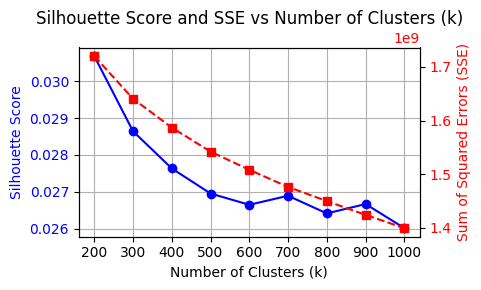

In [468]:
fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot Silhouette Score
ax1.plot(k_values_5cat, scores_5_cat, marker='o', linestyle='-', color='b', label='Silhouette Score')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(k_values_5cat)
ax1.grid(True)

# Create a second y-axis for SSE
ax2 = ax1.twinx()
ax2.plot(k_values_5cat, sse_5_cat, marker='s', linestyle='--', color='r', label='SSE')
ax2.set_ylabel('Sum of Squared Errors (SSE)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title
plt.title('Silhouette Score and SSE vs Number of Clusters (k)')

# Show the plot
fig.tight_layout()
plt.show()

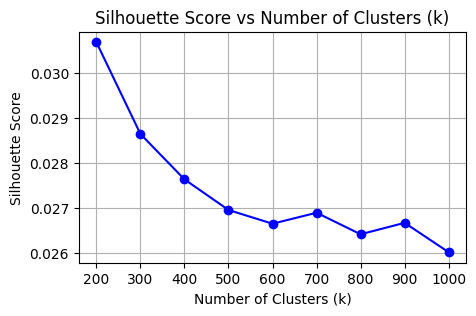

In [469]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3)) 
plt.plot(k_values_5cat, scores_5_cat, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters (k)')
plt.xticks(k_values_5cat)
plt.grid(True)
plt.show()

### Evaluate best k means for 20 categories

In [470]:
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

scores_20_cat = []
sse_20_cat = []

def evaluate_k_means_fast(descriptors, k_values):
    best_k = None
    best_score = -1
    
    
    for k in k_values:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=500).fit(descriptors)
        labels = kmeans.labels_
        score = silhouette_score(descriptors, labels, sample_size=min(1000, len(descriptors)))  # Sample to speed up
        scores_20_cat.append(score)
        sse = kmeans.inertia_  # Sum of squared distances of samples to their closest cluster center.
        sse_20_cat.append(sse)
        print(f'k={k}, Silhouette Score={score}')
        
        if score > best_score:
            best_score = score
            best_k = k
    
    return best_k, scores_20_cat

pca = IncrementalPCA(n_components=100, batch_size=500)  # Adjust batch_size as needed
print("Computing PCA for 20 categories...")
reduced_descriptors_20 = pca.fit_transform(train_descriptors_matrix)

print("Normalizing features for 20 categories...")
scaler = StandardScaler()
reduced_descriptors_20 = scaler.fit_transform(reduced_descriptors_20)

k_values_20cat = range(500, 2001, 250)

result = evaluate_k_means_fast(reduced_descriptors_20, k_values_20cat)

best_k_20cat = int(result[0])  # Extract the first element of the tuple
print(f'Best k for 20 categories: {best_k_20cat}')

Computing PCA for 20 categories...
Normalizing features for 20 categories...


c:\Users\jonaz\anaconda3\envs\VIP-ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


k=500, Silhouette Score=-0.10973522590264659


c:\Users\jonaz\anaconda3\envs\VIP-ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


k=750, Silhouette Score=-0.1002272036966099


c:\Users\jonaz\anaconda3\envs\VIP-ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


k=1000, Silhouette Score=-0.0920911475061397


c:\Users\jonaz\anaconda3\envs\VIP-ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


k=1250, Silhouette Score=-0.07708785396740846


c:\Users\jonaz\anaconda3\envs\VIP-ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


k=1500, Silhouette Score=-0.07389492930695604


c:\Users\jonaz\anaconda3\envs\VIP-ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


k=1750, Silhouette Score=-0.06547041029768236


c:\Users\jonaz\anaconda3\envs\VIP-ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


k=2000, Silhouette Score=-0.06831947641812998
Best k for 20 categories: 1750


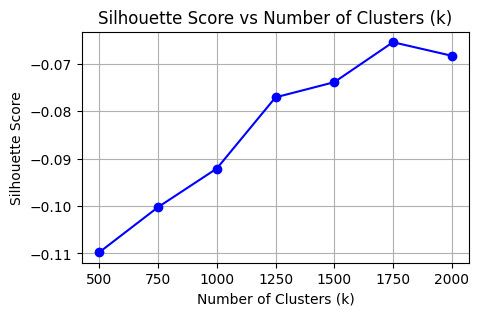

In [471]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3)) 
plt.plot(k_values_20cat, scores_20_cat, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters (k)')
plt.xticks(k_values_20cat)
plt.grid(True)
plt.show()

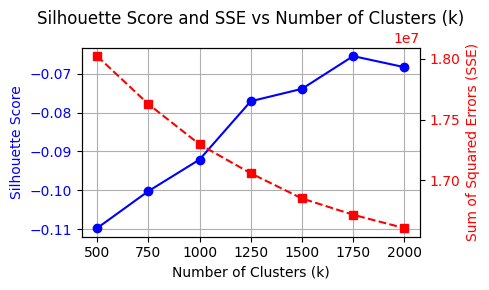

In [472]:
fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot Silhouette Score
ax1.plot(k_values_20cat, scores_20_cat, marker='o', linestyle='-', color='b', label='Silhouette Score')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(k_values_5cat)
ax1.grid(True)

# Create a second y-axis for SSE
ax2 = ax1.twinx()
ax2.plot(k_values_20cat, sse_20_cat, marker='s', linestyle='--', color='r', label='SSE')
ax2.set_ylabel('Sum of Squared Errors (SSE)', color='r')
ax2.set_xticks(k_values_20cat)
ax2.tick_params(axis='y', labelcolor='r')

# Add a title
plt.title('Silhouette Score and SSE vs Number of Clusters (k)')

# Show the plot
fig.tight_layout()
plt.show()

Then we implement the k-means clustering on the training descriptors for the 2 different subsets. Clustering results to classify each descriptor to the closest cluster center. Then, for each image, count the number of descriptors assigned to each cluster to form a histogram (BoW vector).

In [473]:
kmeans_5 = KMeans(n_clusters=best_k_5cat, random_state=42)
kmeans_5.fit(train_descriptors_matrix_small)

visual_words = kmeans_5.cluster_centers_ # Get the cluster centers (visual words)

print(f'Number of visual words (clusters): {visual_words.shape[0]}')

Number of visual words (clusters): 200


In [474]:
kmeans_20 = KMeans(n_clusters=best_k_20cat, random_state=42)
kmeans_20.fit(train_descriptors_matrix)

visual_words_20 = kmeans_20.cluster_centers_

print(f'Number of visual words (clusters): {visual_words_20.shape[0]}')

Number of visual words (clusters): 1750


BoW representations 

In [475]:
def form_bow(descriptors_list, kmeans):
    bow_list = []
    for descriptors in descriptors_list:
        labels = kmeans.predict(descriptors) # # Predict the closest cluster for each descriptor
        bow = np.bincount(labels, minlength=kmeans.n_clusters) # Create a histogram of cluster assignments
        bow_list.append(bow)
    return np.array(bow_list)

bow_list_5cat = form_bow(train_descriptors_small, kmeans_5)

print(f'Number of BoW vectors for the training set with 5 categories: {len(bow_list_5cat)}')

Number of BoW vectors for the training set with 5 categories: 50


In [476]:
# TO DO:
bow_list_20cat = form_bow(train_descriptors, kmeans_20)
print(f'Number of BoW vectors for the training set with 20 categories: {len(bow_list_20cat)}')

Number of BoW vectors for the training set with 20 categories: 561


# 2 Indexing

TASK: The next step consists in content indexing. For each image in the test set you
should:

• Extract the SIFT descriptors of the feature points in the image,

• Project the descriptors onto the codebook, i.e., for each descriptor the
closest cluster prototype should be found,

• Construct the generated corresponding bag of words, i.e, word histogram.
Please note that you have already performed the same steps for the training
images during codebook generation.

Now construct and save a table that would contain, per entry at least the
file name, the true category, if it belongs to the training- or test set, and the
corresponding bag of words / word histogram. The table need only be computed
once and then used repeatably in the following retrieval experiments.

In [477]:
test_descriptors_small = []
for img_path in test_imgs_5cat:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    descriptors = compute_sift_descriptors(img)
    if descriptors is not None:
        test_descriptors_small.append(descriptors)

test_descriptors_matrix_small = np.vstack(test_descriptors_small)

print(f'Total number of test descriptors for the test set with 5 categories: {test_descriptors_matrix_small.shape[0]}')

Total number of test descriptors for the test set with 5 categories: 23177


In [478]:
bow_list_test_5cat = form_bow(test_descriptors_small, kmeans_5)

print(f'Number of BoW vectors for the test set with 5 categories: {len(bow_list_test_5cat)}')

Number of BoW vectors for the test set with 5 categories: 50


In [479]:
test_descriptors = []
for img_path in test_imgs_20cat:
   img = cv2.imread(img_path)
   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   descriptors = compute_sift_descriptors(img)
   if descriptors is not None:
       test_descriptors.append(descriptors)

test_descriptors_matrix = np.vstack(test_descriptors)

print(f'Total number of test descriptors for the test set with 20 categories: {test_descriptors_matrix.shape[0]}')

bow_list_test_20cat = form_bow(test_descriptors, kmeans_20)

print(f'Number of BoW vectors for the test set with 20 categories: {len(bow_list_test_20cat)}')

Total number of test descriptors for the test set with 20 categories: 249370
Number of BoW vectors for the test set with 20 categories: 561


In [480]:
import pickle
import pandas as pd
from pathlib import Path

data_5cat = []

for img_path, bow in zip(train_imgs_5cat, bow_list_5cat):
    category = Path(img_path).parent.name
    data_5cat.append([img_path, category, 'train', bow])

for img_path, bow in zip(test_imgs_5cat, bow_list_test_5cat):
    category = Path(img_path).parent.name
    data_5cat.append([img_path, category, 'test', bow])

# Create DataFrame
df_bow_5cat = pd.DataFrame(data_5cat, columns=['file_name', 'category', 'set_type', 'bow'])

# Save as Pickle
df_bow_5cat.to_pickle('bow_table_5cat.pkl')

print("Table saved as 'bow_table_5cat.pkl'")

Table saved as 'bow_table_5cat.pkl'


In [481]:
data_20cat = []

for img_path, bow in zip(train_imgs_20cat, bow_list_20cat):
    category = Path(img_path).parent.name
    bow_array = np.array(bow, dtype=np.float64)  # Ensure it's a NumPy array
    data_20cat.append([img_path, category, 'train', bow_array])

for img_path, bow in zip(test_imgs_20cat, bow_list_test_20cat):
    category = Path(img_path).parent.name
    bow_array = np.array(bow, dtype=np.float64)  # Ensure it's a NumPy array
    data_20cat.append([img_path, category, 'test', bow_array])

# Create DataFrame
df_bow_20cat = pd.DataFrame(data_20cat, columns=['file_name', 'category', 'set_type', 'bow'])

# Save as Pickle
df_bow_20cat.to_pickle('bow_table_20cat.pkl')

print("Table saved as 'bow_table_20cat.pkl'")

Table saved as 'bow_table_20cat.pkl'


# 3 Retrieving

TASK: Finally, you should implement retrieving of images using some of the similarity
measures discussed in the course slides. You may use: 

• common words

• tf-ifd similarity

• Bhattacharyya distance or Kullback-Leibler divergence

Please argue for your choice or report the differences in result when applying
the different measures.

Your report should show commented results for two experiments. 

In the first
you consider retrieving training images. 

In the second you test how well you
can classify test images. Otherwise the two test are identical. 

For each test you
should count:
• The mean reciprocal rank (i.e. the average across all queries of 1/ranki ,
where ranki is the rank position of the first correct category for the i’th
query).
• How often (in per cent) the correct category is in top-3

## 5 category subset

In [482]:
df_5cat = pd.read_pickle('bow_table_5cat.pkl')

In [483]:
def parse_bow(bow_string):
    """
    Parses a bag-of-words (BOW) string representation into a NumPy array.
    """
    if isinstance(bow_string, np.ndarray):  # Already a NumPy array
        return bow_string  

    if isinstance(bow_string, str):  # If it's a string, process it
        clean_bow = bow_string.replace('\n', ' ').replace('  ', ' ').strip('[]')
        bow_list = [float(x) for x in clean_bow.split()]
        return np.array(bow_list)

    raise ValueError(f"Unexpected type in 'bow' column: {type(bow_string)}")  


def common_words_similarity(bow1, bow2):
    """
    Computes the similarity between two BOW vectors based on the number of common words.

    Parameters:
    - bow1: NumPy array, the first BOW vector.
    - bow2: NumPy array, the second BOW vector.

    Returns:
    - Integer representing the sum of the minimum word counts for each term in the vectors.
    """
    for i in range(5):
        print(f"Similarity between row {i} and row {i+1}: {common_words_similarity(df.iloc[i]['bow'], df.iloc[i+1]['bow'])}")
    return np.sum(np.minimum(bow1, bow2))


def compute_idf(df):
    num_docs = len(df)

    # Ensure BOW values are properly parsed before stacking
    df["bow"] = df["bow"].apply(parse_bow)  

    term_frequencies = np.sum(np.vstack(df['bow']), axis=0)  # Sum BOW vectors across all documents

    idf = np.log((num_docs + 1) / (1 + term_frequencies)) + 1  # Smooth IDF
    return idf


def tf_idf_similarity(bow1, bow2, idf):
    """
    Computes the cosine similarity between two TF-IDF vectors.

    Parameters:
    - bow1: NumPy array, the first BOW vector.
    - bow2: NumPy array, the second BOW vector.
    - idf: NumPy array, precomputed IDF values.

    Returns:
    - Float representing the cosine similarity between the two TF-IDF vectors.
    """
    bow1 = np.array(bow1, dtype=np.float64)
    bow2 = np.array(bow2, dtype=np.float64)
    idf = np.array(idf, dtype=np.float64)

    # Ensure the IDF shape matches
    if bow1.shape != idf.shape:
        idf = np.resize(idf, bow1.shape)

    tf_idf1 = bow1 * idf
    tf_idf2 = bow2 * idf

    return 1 - cosine(tf_idf1, tf_idf2)


def bhattacharyya_distance(bow1, bow2):
    bow1 = np.array(bow1, dtype=np.float64).flatten()
    bow2 = np.array(bow2, dtype=np.float64).flatten()

    bow1 = bow1 / (np.sum(bow1) + 1e-10)  # Normalize and prevent division by zero
    bow2 = bow2 / (np.sum(bow2) + 1e-10)

    score = np.sum(np.sqrt(bow1 * bow2)) + 1e-10  # Prevent log(0)
    return -np.log(score)


def kl_divergence(bow1, bow2):
    bow1 = np.array(bow1, dtype=np.float64).flatten()  # Convert to 1D float array
    bow2 = np.array(bow2, dtype=np.float64).flatten()

    # Ensure no zeros (since log(0) is undefined in KL divergence)
    bow1[bow1 == 0] = 1e-10
    bow2[bow2 == 0] = 1e-10

    return entropy(bow1, bow2)

def retrieve_images(query_bow, df, similarity_measure, top_k=5):
    query_bow = parse_bow(query_bow)  # Ensure query BoW is also a NumPy array
    similarities = [(row['file_name'], row['category'], similarity_measure(query_bow, parse_bow(row['bow']))) 
                    for _, row in df.iterrows() if parse_bow(row['bow']).size > 0]
    return sorted(similarities, key=lambda x: -x[2])[:top_k]  # Sort in descending order


def evaluate_retrieval(df, similarity_measure):
    mrr, top3_count, num_queries = 0, 0, len(df)
    for query_index in range(num_queries):
        query_bow, query_category = df.iloc[query_index]['bow'], df.iloc[query_index]['category']
        results = sorted(retrieve_images(query_bow, df, similarity_measure), key=lambda x: -x[2])  # Ensure descending order
        rank = next((i for i, result in enumerate(results) if result[1] == query_category), None)
        if rank is not None:
            mrr += 1 / (rank + 1)
            if rank < 3:
                top3_count += 1
    return mrr / num_queries, (top3_count / num_queries) * 100

IndentationError: expected an indented block after 'for' statement on line 27 (1661522552.py, line 28)

In [452]:
# Function to perform experiments and print results
def perform_experiment(set_name, dataset, similarity_measures):
    print(f"\n--- Results for {set_name} Set ---")
    for name, similarity_measure in similarity_measures.items():
        mrr, top3 = evaluate_retrieval(dataset, similarity_measure)
        print(f"Similarity Measure: {name}")
        print(f"  - Mean Reciprocal Rank (MRR): {mrr:.4f}")
        print(f"  - Top-3 Accuracy: {top3:.2f}%")

### Experiment 1 - 5 categories - retrieving training images

In [453]:
training_set = df_5cat[df_5cat['set_type'] == 'train'].copy()

training_set['bow'] = training_set['bow'].apply(parse_bow)

idf = compute_idf(training_set)

similarity_measures = { 'Common Words': common_words_similarity, 
                       'TF-IDF': lambda bow1, bow2: tf_idf_similarity(bow1, bow2, idf), 
                       'Bhattacharyya': bhattacharyya_distance, 
                       'KL Divergence': kl_divergence }

perform_experiment("Training", training_set, similarity_measures)



--- Results for Training Set ---
Similarity Measure: Common Words
  - Mean Reciprocal Rank (MRR): 0.9800
  - Top-3 Accuracy: 98.00%
Similarity Measure: TF-IDF
  - Mean Reciprocal Rank (MRR): 1.0000
  - Top-3 Accuracy: 100.00%
Similarity Measure: Bhattacharyya
  - Mean Reciprocal Rank (MRR): 0.1903
  - Top-3 Accuracy: 20.00%
Similarity Measure: KL Divergence
  - Mean Reciprocal Rank (MRR): 0.2497
  - Top-3 Accuracy: 22.00%


### Experiment 2 - 5 categories - retrieving test images

In [ ]:
test_set = df_5cat[df_5cat['set_type'] == 'test'].copy()

test_set['bow'] = test_set['bow'].apply(parse_bow)

perform_experiment("Test", test_set, similarity_measures)


--- Results for Test Set ---
Similarity Measure: Common Words
  - Mean Reciprocal Rank (MRR): 0.9800
  - Top-3 Accuracy: 100.00%
Similarity Measure: TF-IDF
  - Mean Reciprocal Rank (MRR): 1.0000
  - Top-3 Accuracy: 100.00%
Similarity Measure: Bhattacharyya
  - Mean Reciprocal Rank (MRR): 0.2243
  - Top-3 Accuracy: 28.00%
Similarity Measure: KL Divergence
  - Mean Reciprocal Rank (MRR): 0.2973
  - Top-3 Accuracy: 38.00%


## Visualizing the results

In [455]:
def visualize_retrieval(query_index, df, similarity_measure, top_k=5):
    query_row = df.iloc[query_index]
    query_img_path = query_row['file_name']
    query_category = query_row['category']
    query_bow = query_row['bow']

    # Retrieve images
    retrieved_images = retrieve_images(query_bow, df, similarity_measure, top_k)
    
    if not retrieved_images:
        print("No images retrieved! Check similarity measure or dataset.")
        return

    # Load query image
    query_img = cv2.imread(query_img_path)
    if query_img is None:
        print(f"Query image not found: {query_img_path}")
        query_img = np.ones((100, 100, 3), dtype=np.uint8) * 255  # Default white image

    query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)

    # Set up plot
    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 5))
    fig.suptitle(f"Retrieval using {similarity_measure.__name__}", fontsize=14)
    
    axes[0].imshow(query_img)
    axes[0].set_title("Query Image")
    axes[0].axis("off")

    # Load and display retrieved images
    for i, (img_path, category, similarity) in enumerate(retrieved_images):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load: {img_path}")
            img = np.ones((100, 100, 3), dtype=np.uint8) * 255  # Default white image

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"{category}\nSim: {similarity:.2f}")
        axes[i + 1].axis("off")

    plt.show()

In [456]:
df_5cat['bow'] = df_5cat['bow'].apply(lambda x: np.array(x, dtype=np.float64))

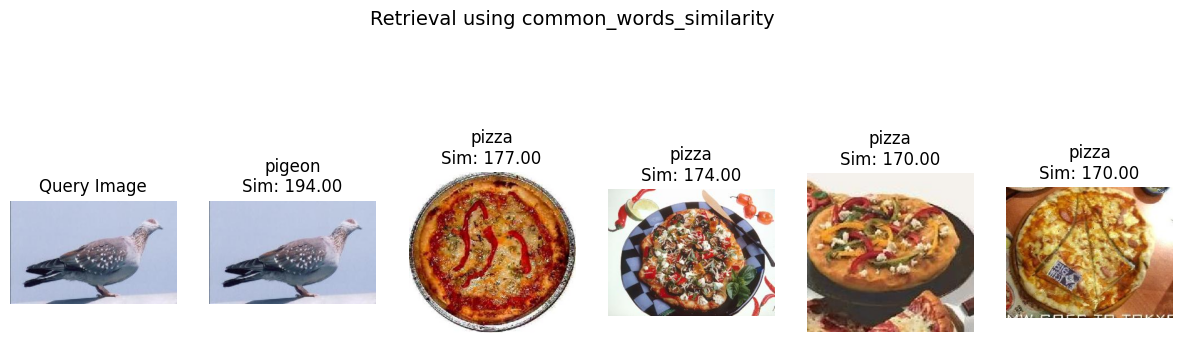

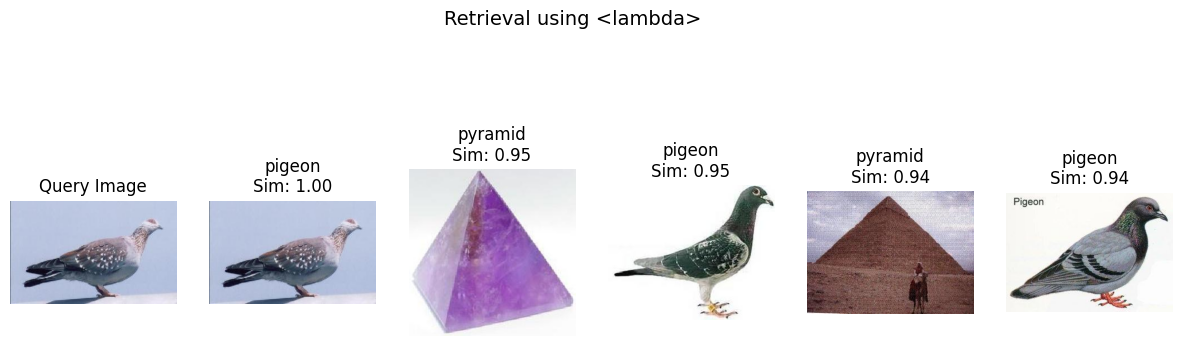

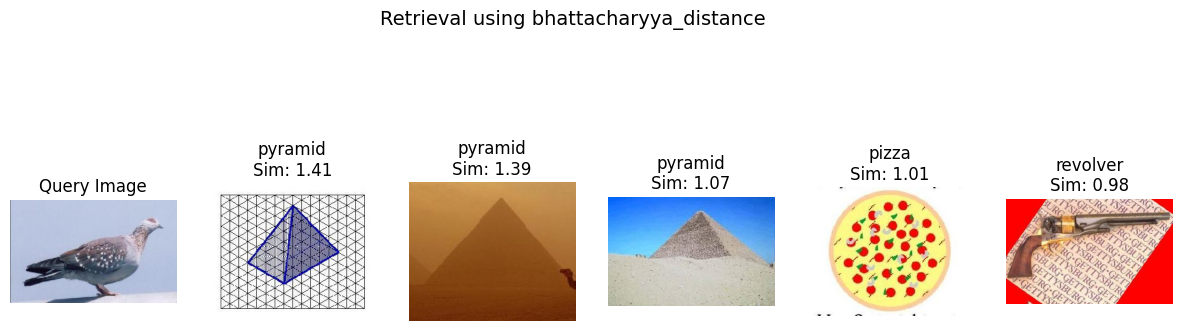

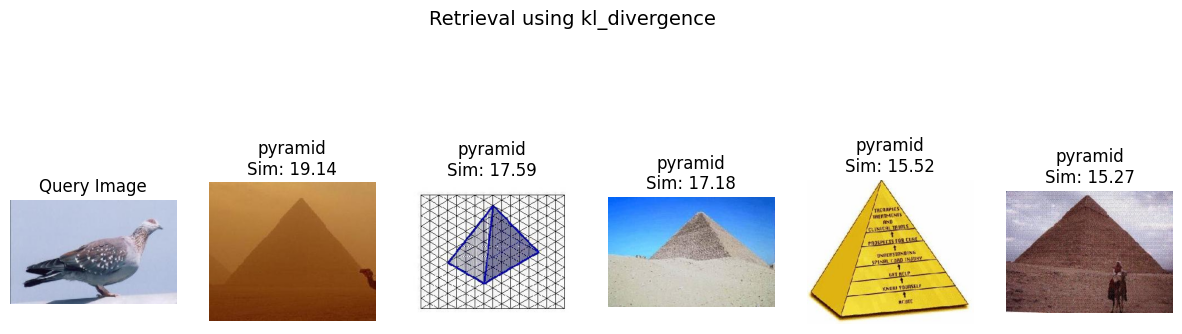

In [457]:
query_image = 3
visualize_retrieval(query_image, df_5cat, common_words_similarity)
visualize_retrieval(query_image, df_5cat, lambda bow1, bow2: tf_idf_similarity(bow1, bow2, compute_idf(df_5cat)))
visualize_retrieval(query_image, df_5cat, bhattacharyya_distance)
visualize_retrieval(query_image, df_5cat, kl_divergence)  

# 20 category subset

In [419]:
df_20cat = pd.read_pickle('bow_table_20cat.pkl')

In [420]:
# Function to perform experiments and print results
def perform_experiment(set_name, dataset, similarity_measures):
    print(f"\n--- Results for {set_name} Set ---")
    for name, similarity_measure in similarity_measures.items():
        mrr, top3 = evaluate_retrieval(dataset, similarity_measure)
        print(f"Similarity Measure: {name}")
        print(f"  - Mean Reciprocal Rank (MRR): {mrr:.4f}")
        print(f"  - Top-3 Accuracy: {top3:.2f}%")

### Experiment 1 - 20 Categories - Retrieving training images

In [422]:
training_set = df_20cat[df_20cat['set_type'] == 'train'].copy()

training_set['bow'] = training_set['bow'].apply(parse_bow)

idf = compute_idf(training_set)

similarity_measures = { 'Common Words': common_words_similarity, 
                       'TF-IDF': lambda bow1, bow2: tf_idf_similarity(bow1, bow2, idf), 
                       'Bhattacharyya': bhattacharyya_distance, 
                       'KL Divergence': kl_divergence }

perform_experiment("Training", training_set, similarity_measures)


--- Results for Training Set ---
Similarity Measure: Common Words
  - Mean Reciprocal Rank (MRR): 1.0000
  - Top-3 Accuracy: 100.00%
Similarity Measure: TF-IDF
  - Mean Reciprocal Rank (MRR): 1.0000
  - Top-3 Accuracy: 100.00%
Similarity Measure: Bhattacharyya
  - Mean Reciprocal Rank (MRR): 0.0589
  - Top-3 Accuracy: 4.46%
Similarity Measure: KL Divergence
  - Mean Reciprocal Rank (MRR): 0.0496
  - Top-3 Accuracy: 3.74%


### Experiment 2 - 20 Categories

In [486]:
test_set_20 = df_20cat[df_20cat['set_type'] == 'test'].copy()

test_set_20['bow'] = test_set_20['bow'].apply(parse_bow)

perform_experiment("Test", test_set_20, similarity_measures)


--- Results for Test Set ---
Similarity Measure: Common Words
  - Mean Reciprocal Rank (MRR): 1.0000
  - Top-3 Accuracy: 100.00%
Similarity Measure: TF-IDF
  - Mean Reciprocal Rank (MRR): 1.0000
  - Top-3 Accuracy: 100.00%
Similarity Measure: Bhattacharyya
  - Mean Reciprocal Rank (MRR): 0.0547
  - Top-3 Accuracy: 6.95%
Similarity Measure: KL Divergence
  - Mean Reciprocal Rank (MRR): 0.0316
  - Top-3 Accuracy: 4.81%


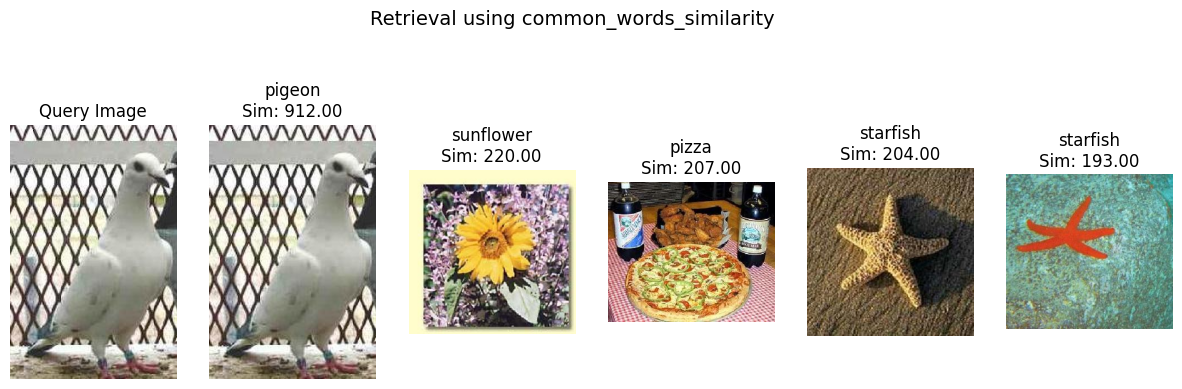

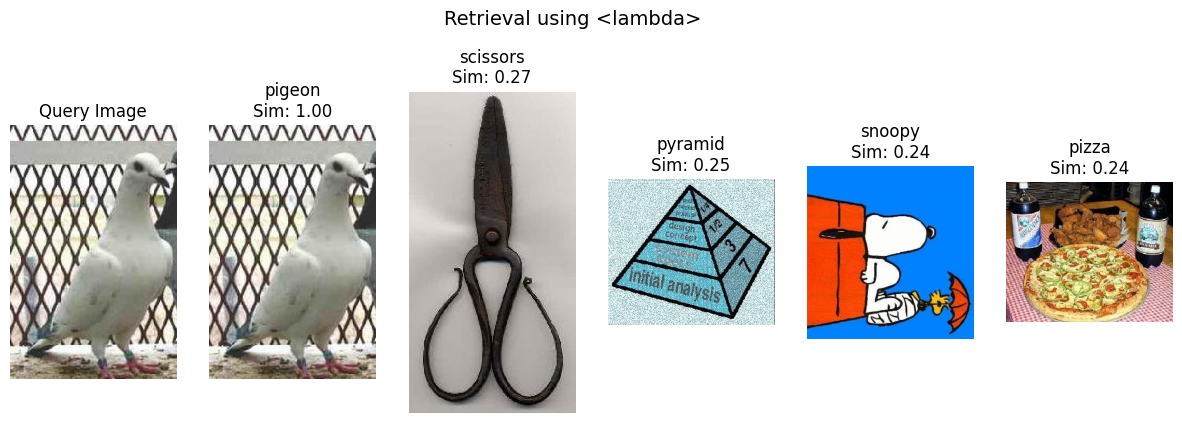

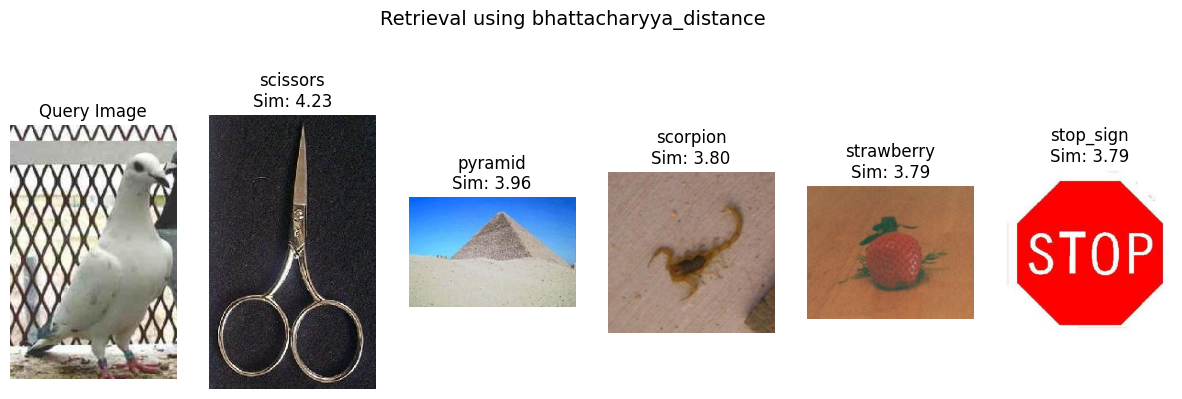

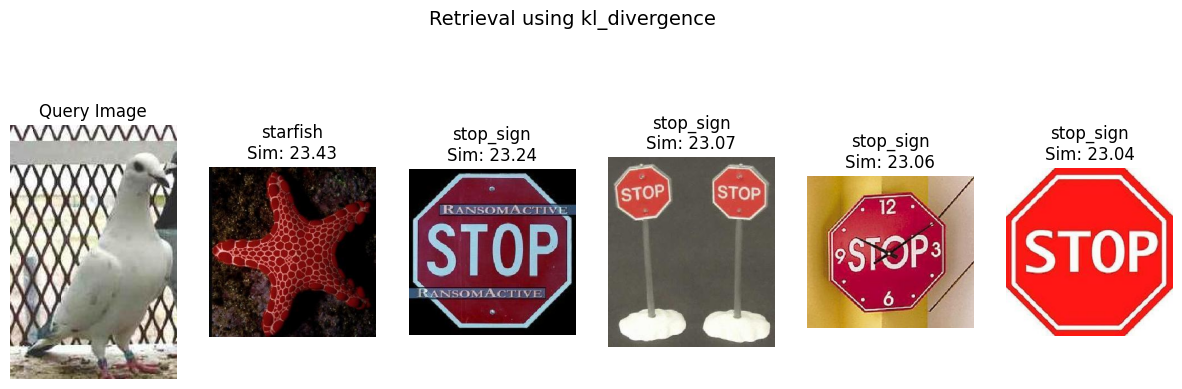

In [442]:
query_image = 3
visualize_retrieval(query_image, df_20cat, common_words_similarity)
visualize_retrieval(query_image, df_20cat, lambda bow1, bow2: tf_idf_similarity(bow1, bow2, compute_idf(df_20cat)))
visualize_retrieval(query_image, df_20cat, bhattacharyya_distance)
visualize_retrieval(query_image, df_20cat, kl_divergence)   